In [16]:
# notebook dependencies 
import os # used in caching
import pandas as pd
import numpy as np

# visualization imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# regular expression import
import re

# JSON import
import json

# importing BeautifulSoup for parsing HTML/XTML
from bs4 import BeautifulSoup as BSoup

# request module for connecting to APIs
from requests import get

# text prepare modules
import acquire
import prepare

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

#sklearn
from sklearn.model_selection import train_test_split

# Wrangling

### Data Acquisition

In [2]:
# Reading in data
df = pd.read_csv('metaverse.csv')

In [3]:
df

,repo,language,readme_contents
0,M3-org/awesome-metaverse,NaN,# Awesome Metaverse [![Awesome](https://awesom...
1,mvs-org/metaverse,C++,Metaverse Core Integration/staging Tree\n=====...
2,webaverse/app,JavaScript,"<img src=""docs/banner.jpeg"" width=100% />\n\n<..."
3,shadowcz007/awesome-metaverse,NaN,"# awesome-metaverse\n<a href=""https://awesome...."
4,vircadia/vircadia,C++,"<p align=""center""><a href=""https://vircadia.co..."
...,...,...,...
993,LinasKo/MetaVerse,C#,# MetaVerse\nVirtual Conference project for Me...
994,saiva11/Metaverse,Vue,NaN
995,dimplehh/metaverse,NaN,# 맥스트 VPS SDK 사용\n\n## VPS 사용\n\nAssets\MaxstA...
996,niksanvijan/MetaVerse,NaN,NaN


In [4]:
# Looking at messy reame_contents
df.readme_contents

0      # Awesome Metaverse [![Awesome](https://awesom...
1      Metaverse Core Integration/staging Tree\n=====...
2      <img src="docs/banner.jpeg" width=100% />\n\n<...
3      # awesome-metaverse\n<a href="https://awesome....
4      <p align="center"><a href="https://vircadia.co...
                             ...                        
993    # MetaVerse\nVirtual Conference project for Me...
994                                                  NaN
995    # 맥스트 VPS SDK 사용\n\n## VPS 사용\n\nAssets\MaxstA...
996                                                  NaN
997                                                  NaN
Name: readme_contents, Length: 998, dtype: object

In [5]:
df.isnull().sum()

repo                 0
language           316
readme_contents    257
dtype: int64

### Data Preparation - Cleaning

In [7]:
# Calling prepare function to clean dataframe
df = prepare.clean_data_objects(df)
df.head()

df shape: (998, 3)


,repo,language,readme_contents
0,M3-org/awesome-metaverse,nan,# Awesome Metaverse [![Awesome](https://awesom...
1,mvs-org/metaverse,C++,Metaverse Core Integration/staging Tree\n=====...
2,webaverse/app,JavaScript,"<img src=""docs/banner.jpeg"" width=100% />\n\n<..."
3,shadowcz007/awesome-metaverse,nan,"# awesome-metaverse\n<a href=""https://awesome...."
4,vircadia/vircadia,C++,"<p align=""center""><a href=""https://vircadia.co..."


In [8]:
# Calling mass_text_clean function to clean readme content
df["readme_contents"] = df["readme_contents"].apply(prepare.mass_text_clean)
df.head()

,repo,language,readme_contents
0,M3-org/awesome-metaverse,nan,awesome awesome awesome badge svg awesome list...
1,mvs-org/metaverse,C++,core integration staging tree build status tra...
2,webaverse/app,JavaScript,img src doc banner jpeg width 100 align center...
3,shadowcz007/awesome-metaverse,nan,awesome href awesome target blank img alt awes...
4,vircadia/vircadia,C++,align center href vircadia img src interface r...


In [9]:
df.language.value_counts()

nan                 316
JavaScript          266
C#                   78
HTML                 72
TypeScript           70
Solidity             27
CSS                  23
Python               22
Rust                 16
Go                   15
C++                  14
Jupyter Notebook     11
Java                  7
ShaderLab             7
SCSS                  6
Vue                   5
Shell                 5
PHP                   5
SuperCollider         3
Clojure               3
Batchfile             2
Roff                  2
Swift                 2
C                     2
GLSL                  2
GDScript              2
Objective-C           2
Kotlin                2
HCL                   1
EJS                   1
PowerShell            1
Svelte                1
TeX                   1
Objective-C++         1
Cadence               1
Metal                 1
R                     1
LSL                   1
ASP.NET               1
Name: language, dtype: int64

In [10]:
# Update language function to reduce noises in language, function writeen by B.G.
def update_languages(df):
    ''' Dataset has multiple languages.  SOme languages are itterations of other languages.
    This function is to replace some of the languages names so the are in the same category'''
    # Jupyter notebook as Python
    df=df.replace('Jupyter Notebook', 'Python')
    # C Related Languages
    df=df.replace(('Objective-C++','Objective-C','C','C++','C#','SuperCollider','GLSL'),'C')
    # Java Related Languages ans sublanguages
    df=df.replace(('JavaScript', 'Vue','Clojure','Kotlin','EJS'), 'Java')
    # TypeScript Languages
    df=df.replace('Svelte','TypeScript')
    # Microsoft languages for windows applications
    df=df.replace(('PowerShell','Batchfile','Shell'),'Microsoft')
    # iOS related languages
    df=df.replace(('Metal','Swift'),'iOS')
    # languages with < 10 usage
    df=df.replace(('Microsoft','ShaderLab','SCSS','PHP','iOS','GDScript','Roff','HCL','TeX', 'Cadence','R','LSL','ASP.NET'),'other')
    
    return df

In [11]:
# Using function to clean language
df = update_languages(df)

In [12]:
# Check the cleaned language
df.language.value_counts()

nan           316
Java          284
C             102
HTML           72
TypeScript     71
other          39
Python         33
Solidity       27
CSS            23
Rust           16
Go             15
Name: language, dtype: int64

### Data Preparation - Splitting

In [13]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [14]:
# Calling function to split data into train, validate, test
train, validate, test = train_validate_test_split(df, 'language')

***

# Explore

## Target Variable Univariate Analysis

#### Train Language Percentages

In [15]:
labels = pd.concat([train.language.value_counts(),
                    train.language.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
nan,177,0.317204
Java,159,0.284946
C,57,0.102151
TypeScript,40,0.071685
HTML,40,0.071685
other,22,0.039427
Python,18,0.032258
Solidity,15,0.026882
CSS,13,0.023297
Rust,9,0.016129


In [36]:
labels.index

Index(['nan', 'Java', 'C', 'TypeScript', 'HTML', 'other', 'Python', 'Solidity',
       'CSS', 'Rust', 'Go'],
      dtype='object')

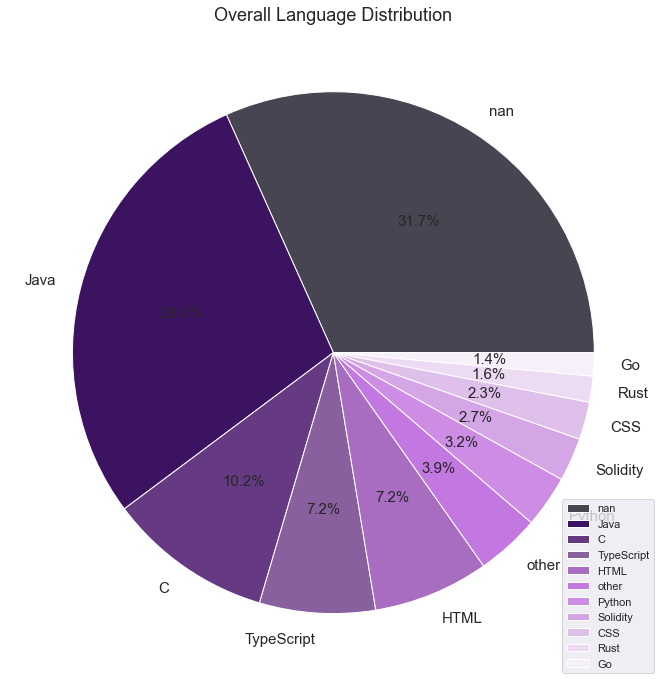

In [42]:
plt.figure(figsize=(16,12))
mylabels = ['nan', 'Java', 'C', 'TypeScript', 'HTML', 'other', 'Python', 'Solidity',
       'CSS', 'Rust', 'Go']
mycolors = ['#484553', '#3c1361', '#663a82', '#89609e', '#a86cc1', '#c377e0', '#cd8de5', '#d5a6e6', '#dfc0eb', '#eddbf4', '#f7f0fa']
textprops = {"fontsize":15}
plt.pie(labels.percent, labels = mylabels, colors = mycolors, textprops=textprops, autopct='%.1f%%')
plt.legend()
plt.title('Overall Language Distribution',fontsize=18)
plt.show() 


### Takeaway: Besides the NaN values, Java and C/C++ are the most common languages for metaverse repos.

***

## Question 1: What are the most common words in READMEs?

### Takeaway:

***

## Question 2: Does the length of the README vary by programming language?

### Takeaway:

***

## Question 3: Do different programming languages use a different number of unique words?

### Takeaway:

***

## Question 4: Are there any words that uniquely identify a programming language?

### Takeaway:

***